# Introduction to ML - Additional Challenge #1

## Beer Consumption in Sao Paulo

    a. Load the beer consumption data from Sao Paulo (beer_consumption.csv) and split it into 80% training and 20% test data. (Better: use a 5-fold cross validation).

    b. Train different linear models (LinearRegression, Lasso, RidgeRegression,ElasticNet) to predict the beer consumption based on the given data

    c. Find the best model by tuning hyperparameters and feature engineering (e.g.ignoring some features or creating new ones).



In [1341]:
# Import necessary libraries
import pandas as pd
import numpy as np
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [1342]:
# Load and Preprocess Data
beer_data = pd.read_csv('data/beer_consumption.csv')
beer_data.columns = ["Date", "Avg Temp(C)", "Min Temp(C)", "Max Temp(C)", "Rainfall(mm)", "Weekend", "Beer Consumption(L)"]
beer_data.dropna(inplace=True)
comma_columns = ["Avg Temp(C)", "Min Temp(C)", "Max Temp(C)", "Rainfall(mm)"]
beer_data[comma_columns] = beer_data[comma_columns].apply(lambda x: x.str.replace(',', '.').astype(float))
beer_data['Date'] = pd.to_datetime(beer_data['Date'], format='%Y-%m-%d')
beer_data["Weekend"] = beer_data["Weekend"].astype(int)


In [1343]:
# Feature Engineering 1
beer_data['Temperature_Range'] = beer_data['Max Temp(C)'] - beer_data['Min Temp(C)']
beer_data['Weekend_Temp'] = beer_data['Weekend'] * beer_data['Avg Temp(C)']
beer_data['Weekly_Avg'] = beer_data['Beer Consumption(L)'].rolling(window=7, min_periods=1).mean()
beer_data['Month'] = beer_data['Date'].dt.month
beer_data['Season'] = beer_data['Month'].apply(lambda x: (x%12 + 3)//3)
beer_data['DayOfWeek'] = beer_data['Date'].dt.dayofweek
season_dummies = pd.get_dummies(beer_data['Season'], prefix='Season')
beer_data = pd.concat([beer_data, season_dummies], axis=1)


In [1344]:
# Feature Engineering 2

# Rolling means for weekly, bi-weekly, and monthly
beer_data['Weekly_Avg'] = beer_data['Beer Consumption(L)'].rolling(window=7,min_periods=1).mean()
beer_data['Bi_Weekly_Avg'] = beer_data['Beer Consumption(L)'].rolling(window=14,min_periods=1).mean()
beer_data['Monthly_Avg'] = beer_data['Beer Consumption(L)'].rolling(window=30,min_periods=1).mean()
beer_data['Quarterly_Avg'] = beer_data['Beer Consumption(L)'].rolling(window=91,min_periods=1).mean()

# Apply the sine and cosine transformations
#beer_data['cos_month'] = np.cos(2 * np.pi * beer_data['Month'] / 12)
#beer_data['sin_month'] = np.sin(2 * np.pi * beer_data['Month'] / 12)
beer_data['cos_day'] = np.cos(2 * np.pi * beer_data['DayOfWeek'] / 7)
beer_data['sin_day'] = np.sin(2 * np.pi * beer_data['DayOfWeek'] / 7)
beer_data['cos_season'] = np.cos(2 * np.pi * beer_data['Season'] / 4)
beer_data['sin_season'] = np.sin(2 * np.pi * beer_data['Season'] / 4)

beer_data['AvgMaxTemp']=beer_data['Max Temp(C)']*beer_data['Avg Temp(C)']


In [1345]:
# Incorporate Holidays
years = beer_data['Date'].dt.year.unique().astype(int)
argentina=holidays.Argentina(years=[year for year in years]) #neighbour
uruguay=holidays.Uruguay(years=[year for year in years]) #neighbour
paraguay=holidays.Paraguay(years=[year for year in years]) #neighbour
euro=holidays.EuropeanCentralBank(years=[year for year in years]) #financial holidays in europe
brazil_holidays = holidays.Brazil(years=[year for year in years],state='RJ')

holidays = brazil_holidays + euro + argentina + uruguay + paraguay

beer_data['Is_Holiday'] = beer_data['Date'].apply(lambda x: 1 if x in holidays else 0)


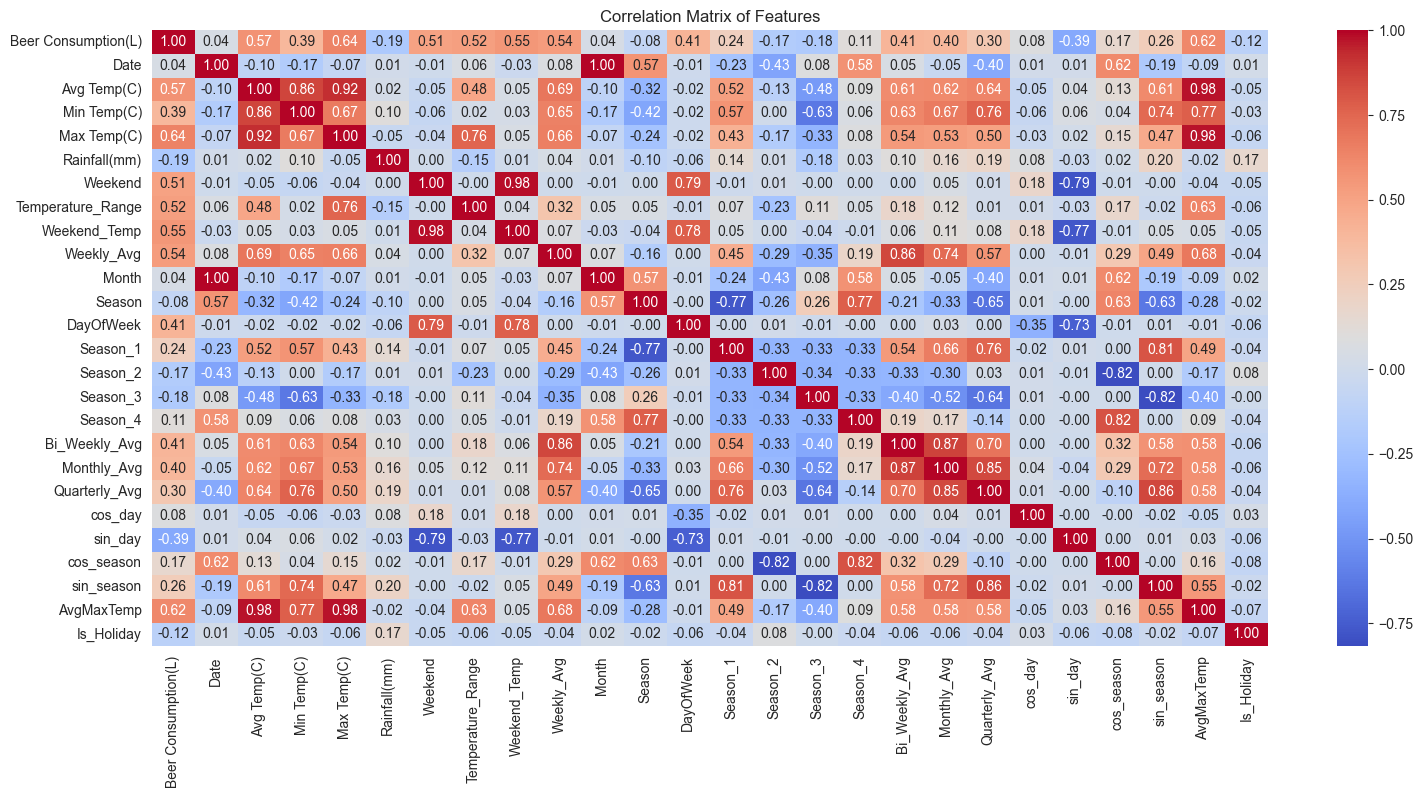

In [1346]:

all_features=['Beer Consumption(L)', 'Date', 'Avg Temp(C)', 'Min Temp(C)', 'Max Temp(C)', 'Rainfall(mm)','Weekend', 'Temperature_Range', 'Weekend_Temp','Weekly_Avg', 'Month', 'Season', 'DayOfWeek', 'Season_1', 'Season_2','Season_3', 'Season_4', 'Bi_Weekly_Avg', 'Monthly_Avg', 'Quarterly_Avg','cos_day', 'sin_day', 'cos_season', 'sin_season', 'AvgMaxTemp','Is_Holiday']
beer_data=beer_data[all_features]
correlation= beer_data.corr()
# Visualize the correlation matrix
plt.figure(figsize=(18, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.savefig('data/heatmap.png')
plt.title('Correlation Matrix of Features')
plt.show()

#correlation['Beer Consumption(L)'].sort_values(ascending=False).head(17)


In [1347]:
# different feature variations that were tested

#features=['Avg Temp(C)', 'Min Temp(C)', 'Max Temp(C)', 'Rainfall(mm)','Weekend', 'Is_Holiday', 'sin_month','cos_month', 'sin_day','cos_day','Temperature_Range', 'Weekend_Temp', 'Weekly_Avg', 'Bi_Weekly_Avg','Monthly_Avg', 'sin_season','cos_season']

#features=['Date', 'Avg Temp(C)', 'Min Temp(C)', 'Max Temp(C)', 'Rainfall(mm)','Weekend', 'Beer Consumption(L)', 'Temperature_Range', 'Weekend_Temp','Weekly_Avg', 'Month', 'Season', 'DayOfWeek', 'Season_1', 'Season_2','Season_3', 'Season_4', 'Is_Holiday']

#features=['Max Temp(C)','Is_Holiday','sin_season','cos_season','Temperature_Range','Weekend','Weekend_Temp','Weekly_Avg','sin_season','cos_season']

#features = ['Max Temp(C)', 'Is_Holiday', 'DayOfWeek', 'Temperature_Range', 'Weekend', 'Weekend_Temp', 'Weekly_Avg','Season_1', 'Season_2', 'Season_3', 'Season_4']

features=['AvgMaxTemp','Max Temp(C)','Is_Holiday','Weekend','Weekly_Avg','sin_season','cos_season','sin_day','cos_day']


In [1348]:
# 4. Model Training and Evaluation
X = beer_data[features]
y = beer_data["Beer Consumption(L)"]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=50)
models = [LinearRegression(), Ridge(), Lasso(), ElasticNet()]
for model in models:
    model.fit(train_X, train_y)
    mse_train = mean_squared_error(train_y, model.predict(train_X))
    mse_test = mean_squared_error(test_y, model.predict(test_X))
    print(f"{model.__class__.__name__} - Training MSE: {mse_train}, Test MSE: {mse_test}")

LinearRegression - Training MSE: 5.523473392658196, Test MSE: 4.320087083822687
Ridge - Training MSE: 5.527738174139898, Test MSE: 4.325876369312869
Lasso - Training MSE: 10.708392080272402, Test MSE: 9.178875056348291
ElasticNet - Training MSE: 9.220832482111671, Test MSE: 7.840108775115661


In [1349]:
# Define models and parameters
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet()
}

model_params = {
    'LinearRegression': {},
    'Ridge': {'alpha': [0.1, 0.5, 1, 5, 10, 20]},
    'Lasso': {'alpha': [0.001, 0.01, 0.1, 1, 10]},
    'ElasticNet': {'alpha': [0.001, 0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.5, 0.9]}
}

Training LinearRegression...
Best parameters for LinearRegression: {}
Best CV score for LinearRegression: 5.8534
LinearRegression - Test MSE: 4.3201, Test R2: 0.7654


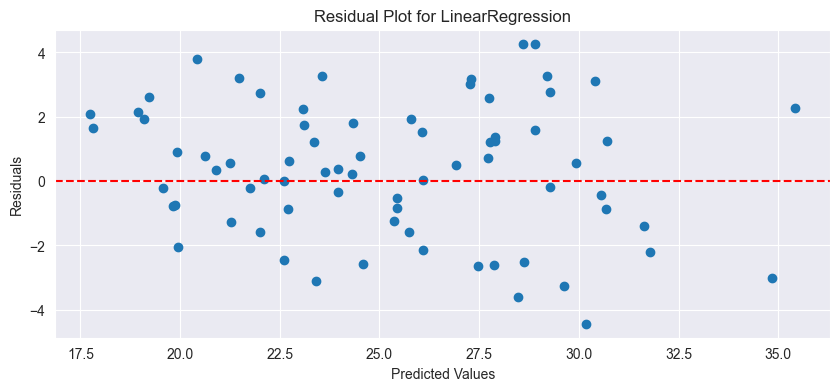

Training Ridge...
Best parameters for Ridge: {'alpha': 0.5}
Best CV score for Ridge: 5.8509
Ridge - Test MSE: 4.3220, Test R2: 0.7653


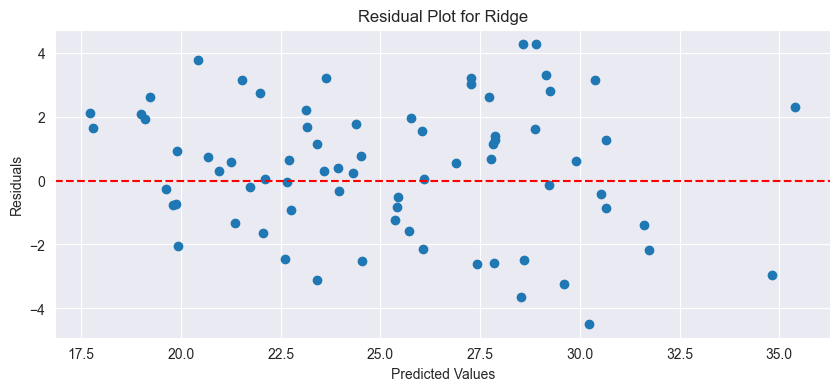

Training Lasso...
Best parameters for Lasso: {'alpha': 0.01}
Best CV score for Lasso: 5.8446
Lasso - Test MSE: 4.3259, Test R2: 0.7651


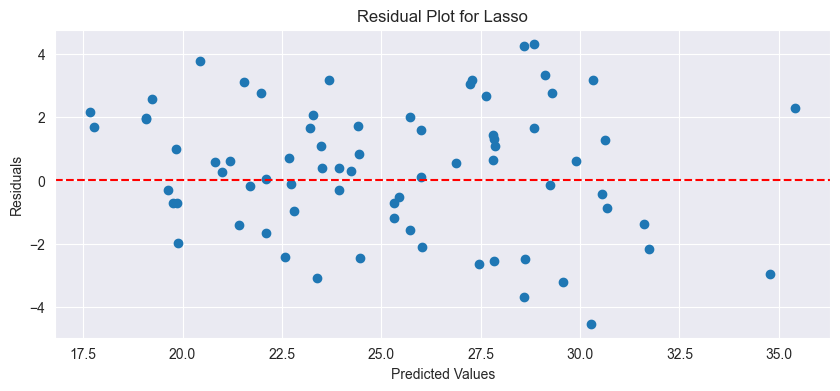

Training ElasticNet...
Best parameters for ElasticNet: {'alpha': 0.01, 'l1_ratio': 0.9}
Best CV score for ElasticNet: 5.8439
ElasticNet - Test MSE: 4.3271, Test R2: 0.7650


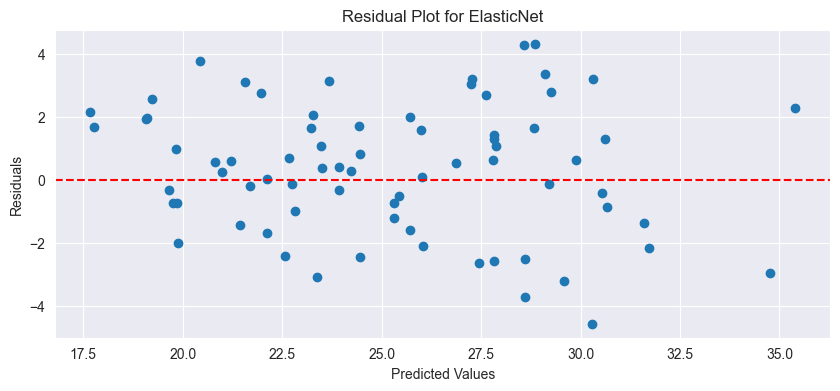

In [1350]:
# Train/test split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=50)

# Model training and evaluation with cross-validation and hyperparameter tuning
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_models = {}

for name, model in models.items():
    print(f"Training {name}...")
    grid_search = GridSearchCV(model, model_params[name], scoring='neg_mean_squared_error', cv=kf)
    grid_search.fit(train_X, train_y)
    best_models[name] = grid_search.best_estimator_
    best_score = np.abs(grid_search.best_score_)
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best CV score for {name}: {best_score:.4f}")

    # Model evaluation on the test set
    y_pred = grid_search.best_estimator_.predict(test_X)
    mse = mean_squared_error(test_y, y_pred)
    r2 = r2_score(test_y, y_pred)
    print(f"{name} - Test MSE: {mse:.4f}, Test R2: {r2:.4f}")

    # Residuals plot
    residuals = test_y - y_pred
    plt.figure(figsize=(10, 4))
    plt.scatter(y_pred, residuals)
    plt.title(f'Residual Plot for {name}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()